In [5]:
import numpy as np
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gc

DEBUG = 'DEBUG'

np.__version__,pd.__version__,sklearn.__version__,tf.__version__

('1.22.3', '1.4.2', '1.0.2', '2.6.0')

In [58]:
from tensorflow.keras.datasets import boston_housing
(train_data,train_labels),(test_data,test_labels) = boston_housing.load_data()
train_data.shape,train_labels.shape,test_data.shape,test_labels.shape

scalery = MinMaxScaler(feature_range=(-1, 1))
train_labels_scaled = scalery.fit_transform(train_labels.reshape(-1,1)).ravel()

scalerX = MinMaxScaler(feature_range=(-1, 1))
train_data_scaled = scalerX.fit_transform(train_data)
test_data_scaled = scalerX.fit_transform(test_data)

In [72]:
def genmodel():
  keras.backend.clear_session()
  H1nodes = train_data.shape[1]*8
  H2nodes = train_data.shape[1]*4
  H3nodes = train_data.shape[1]*2
  model = keras.Sequential([
    layers.InputLayer(input_shape=(13,),name='In')
    #,layers.LayerNormalization(axis=-1,epsilon=0.00005)
    ,layers.Dense(H1nodes,activation='relu',name='H1')
    ,layers.Dropout(0.2)
    ,layers.Dense(H2nodes,activation='relu',name='H2')
    #,layers.Dropout(0.2)
    ,layers.Dense(H3nodes,activation='relu',name='H3')
    #,layers.Dropout(0.2)
    ,layers.Dense(1,activation='linear',name='Out')
  ])
  op = tf.keras.optimizers.RMSprop(learning_rate=0.0005)
  model.compile(optimizer=op,loss='mse',metrics=['mae'])
  model.summary()
  return model

model = genmodel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 104)               1456      
_________________________________________________________________
dropout (Dropout)            (None, 104)               0         
_________________________________________________________________
H2 (Dense)                   (None, 52)                5460      
_________________________________________________________________
H3 (Dense)                   (None, 26)                1378      
_________________________________________________________________
Out (Dense)                  (None, 1)                 27        
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
_________________________________________________________________


In [73]:
%%time
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

kf = KFold(shuffle=True,n_splits=3)
kf.get_n_splits(train_data)

X = train_data_scaled#train_data
y = train_labels_scaled

print(kf)

hists=[]



for train_index, val_index in kf.split(X):
    print("TRAIN:", train_index, "VAL:", val_index)
    X_t, X_val = X[train_index], X[val_index]
    y_t, y_val = y[train_index], y[val_index]
    history = model.fit(X_t,y_t,epochs=300,batch_size=32,validation_data=(X_val,y_val))
    hists.append(history.history)
    model = genmodel()

model = genmodel()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True)
X_t, X_val, y_t, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)
model.fit(X_t,y_t,epochs=400,batch_size=32,validation_data=(X_val,y_val),callbacks=[es])

KFold(n_splits=3, random_state=None, shuffle=True)
TRAIN: [  0   4   6   7   8   9  11  12  13  14  15  16  17  18  19  21  22  23
  24  26  27  28  29  30  31  35  37  38  39  40  41  42  44  46  47  48
  49  55  56  57  58  60  61  62  64  66  67  68  73  74  77  80  81  82
  85  86  88  91  92  93  97  98  99 100 101 102 103 104 105 106 107 110
 111 112 113 114 115 117 118 120 121 122 123 124 125 127 132 133 134 135
 137 138 139 142 144 146 148 150 151 152 153 154 155 156 157 159 160 161
 163 165 167 170 171 172 173 176 177 178 179 182 183 184 185 186 187 189
 190 191 192 193 194 195 196 197 198 199 201 204 206 207 208 209 210 211
 212 213 217 219 220 221 224 226 228 230 233 235 237 238 239 240 242 244
 246 247 248 250 251 252 253 254 255 257 258 259 260 261 263 264 265 266
 267 268 269 271 272 273 275 276 277 279 281 282 283 285 286 287 291 292
 293 294 295 300 301 302 303 304 305 308 309 310 311 312 313 314 316 317
 318 319 320 323 324 325 330 331 333 336 338 339 341 342 343 345 3

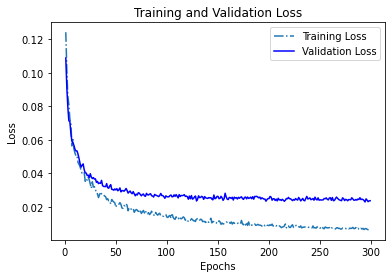

In [74]:
def historyPlotLoss(h):
  i=1
  history_dict = h
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(i,len(loss_values))
  plt.plot(epochs,loss_values[i:],'-.',label='Training Loss')
  plt.plot(epochs,val_loss_values[i:],'b',label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def historyPlotAcc(h):
  history_dict = h
  loss_values = history_dict['accuracy']
  val_loss_values = history_dict['val_accuracy']
  epochs = range(1,len(loss_values)+1)
  plt.plot(epochs,loss_values,'bo',label='Training Accuracy')
  plt.plot(epochs,val_loss_values,'b',label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

#historyPlotLoss(history)
#historyPlotAcc(history)
fhist = {}

feat = 'loss'
fhist[feat]=np.mean([hists[0][feat],hists[1][feat],hists[2][feat]],axis=0)
feat = 'val_loss'
fhist[feat]=np.mean([hists[0][feat],hists[1][feat],hists[2][feat]],axis=0)

historyPlotLoss(fhist)

In [75]:
ypred_scaled = model.predict(test_data_scaled)
#ypred = ypred_scaled.ravel()
ypred = scalery.inverse_transform(ypred_scaled.reshape(-1,1)).ravel()

from sklearn.metrics import mean_squared_error

mean_squared_error(test_labels,ypred,squared=True)

27.634417988136594

In [76]:
ypred - test_labels

array([ 1.72191887e+00, -1.82030373e+00,  1.54733658e-01, -3.02099037e+00,
       -1.36301727e+00, -5.61430168e+00, -4.56542892e+00, -2.39757195e+00,
       -4.16781044e+00, -7.25937386e+00, -1.99710808e+00,  6.22142792e-01,
       -2.49700146e+00, -1.07844505e+01, -5.95570164e+00, -4.36531906e+00,
       -2.40992661e+00, -4.58231735e-01, -4.30186806e+00,  1.84425621e+00,
       -1.49652863e+00,  4.54319458e+00, -1.33526802e+00, -3.18279457e+00,
       -1.72548523e+00, -2.66227531e+00, -3.20594025e+00, -9.08879051e+00,
        1.34893990e+00, -1.80887794e+00, -2.38094444e+00,  6.15286255e-01,
       -1.88259277e+00, -2.28301849e+00, -6.39372025e+00, -3.70897689e+00,
       -1.40843525e+00, -6.44065170e+00, -5.19666252e+00, -1.60127258e+00,
       -1.14530029e+01, -5.34854546e+00, -5.12646732e+00, -9.76277084e+00,
       -9.77127457e+00, -9.25203476e+00, -3.69185295e+00, -2.59505539e+00,
       -1.51679726e+00, -4.82425880e+00, -8.16540947e+00, -3.17723351e+00,
       -3.07666321e+00, -

# AULA PASSADA PARA HISTORICO

In [57]:
from tensorflow.keras.datasets import imdb
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)

In [14]:
def decode_words(word_index,sentence):
  reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
  return " ".join([reverse_word_index.get(i-3,"##") for i in sentence])

decode_words(imdb.get_word_index(),train_data[0])

"## this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ## is an amazing actor and now the same being director ## father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ## and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ## to the two little boy's that played the ## of norman and paul they were just brilliant children are often left out of the ## list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't

In [15]:
def vectorize_sequences(sequences,dimension=10000):
  results=np.zeros((len(sequences),dimension))
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i,j]=1
  return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_t = x_train[:15000]
y_t = y_train[:15000]
x_val = x_train[15000:]
y_val = y_train[15000:]



In [33]:
keras.backend.clear_session()
model = keras.Sequential([
  layers.InputLayer(input_shape=(10000,),name='In')
  ,layers.Dense(16,activation='relu',name='H1')
  #,layers.Dropout(0.2)
  ,layers.Dense(16,activation='relu',name='H2')
  #,layers.Dropout(0.2)
  ,layers.Dense(1,activation='sigmoid',name='Out')
])
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 16)                160016    
_________________________________________________________________
H2 (Dense)                   (None, 16)                272       
_________________________________________________________________
Out (Dense)                  (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(x_t,y_t,epochs=4,batch_size=512,validation_data=(x_val,y_val))

Epoch 1/4
30/30 [==============================] - 6s 135ms/step - loss: 0.5332 - accuracy: 0.7925 - val_loss: 0.4427 - val_accuracy: 0.8256
Epoch 2/4
30/30 [==============================] - 2s 73ms/step - loss: 0.3347 - accuracy: 0.8993 - val_loss: 0.3638 - val_accuracy: 0.8502
Epoch 3/4
30/30 [==============================] - 2s 77ms/step - loss: 0.2439 - accuracy: 0.9231 - val_loss: 0.2961 - val_accuracy: 0.8827
Epoch 4/4
30/30 [==============================] - 2s 74ms/step - loss: 0.1905 - accuracy: 0.9398 - val_loss: 0.2795 - val_accuracy: 0.8892


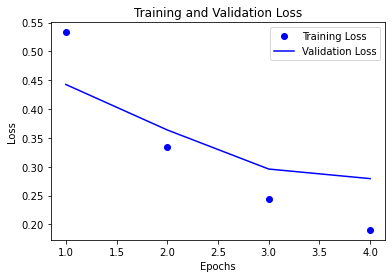

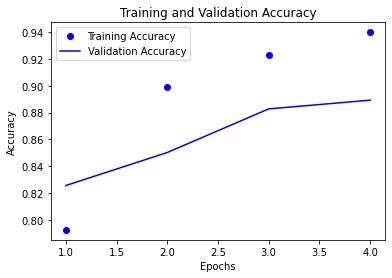

In [35]:
def historyPlotLoss(h):
  history_dict = h.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1,len(loss_values)+1)
  plt.plot(epochs,loss_values,'bo',label='Training Loss')
  plt.plot(epochs,val_loss_values,'b',label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def historyPlotAcc(h):
  history_dict = h.history
  loss_values = history_dict['accuracy']
  val_loss_values = history_dict['val_accuracy']
  epochs = range(1,len(loss_values)+1)
  plt.plot(epochs,loss_values,'bo',label='Training Accuracy')
  plt.plot(epochs,val_loss_values,'b',label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

historyPlotLoss(history)
historyPlotAcc(history)


In [36]:
result = model.evaluate(x_test,y_test)
print(result)

782/782 [==============================] - 11s 13ms/step - loss: 0.3000 - accuracy: 0.8793
[0.30003416538238525, 0.8793200254440308]


In [37]:
from tensorflow.keras.datasets import reuters
(train_data,train_labels),(test_data,test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


In [38]:
def decode_words(word_index,sentence):
  reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
  return " ".join([reverse_word_index.get(i-3,"##") for i in sentence])

decode_words(imdb.get_word_index(),train_data[0])

"## ## ## to just br loved and you i've set and broke many was friends seems him see of how and with movies a with know that him see people film guess are of if the some to okay from without old a though a into in that film thing in that of if is scarecrow outside days a found a looks in that film these about in that was to thought 100 him see good he without be all man a character that as it"

In [56]:
x_train[:valsplit].shape

(7185, 10000)

In [57]:
from tensorflow.keras.utils import to_categorical

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

valsplit = int(x_train.shape[0]*0.8)
x_t = x_train[:valsplit]
y_t = y_train[:valsplit]
x_val = x_train[valsplit:]
y_val = y_train[valsplit:]

In [58]:
x_t.shape,y_t.shape,x_val.shape,y_val.shape,y_t.shape,y_test.shape

((7185, 10000), (7185, 46), (1797, 10000), (1797, 46), (7185, 46), (2246, 46))

In [100]:
keras.backend.clear_session()
model = keras.Sequential([
  layers.InputLayer(input_shape=(10000,),name='In')
  ,layers.Dense(64,activation='relu',name='H1')
  ,layers.Dropout(0.2)
  ,layers.Dense(32,activation='relu',name='H2')
  ,layers.Dropout(0.2)
  ,layers.Dense(46,activation='softmax',name='Out')
])
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
H2 (Dense)                   (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
Out (Dense)                  (None, 46)                1518      
Total params: 643,662
Trainable params: 643,662
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(x_t,y_t,epochs=20,batch_size=512,validation_data=(x_val,y_val))

Epoch 1/20
15/15 [==============================] - 3s 115ms/step - loss: 3.1531 - accuracy: 0.3865 - val_loss: 2.2374 - val_accuracy: 0.6327
Epoch 2/20
15/15 [==============================] - 1s 71ms/step - loss: 1.9953 - accuracy: 0.6149 - val_loss: 1.6053 - val_accuracy: 0.6739
Epoch 3/20
15/15 [==============================] - 1s 67ms/step - loss: 1.5416 - accuracy: 0.6717 - val_loss: 1.3678 - val_accuracy: 0.7012
Epoch 4/20
15/15 [==============================] - 1s 72ms/step - loss: 1.2921 - accuracy: 0.7164 - val_loss: 1.2405 - val_accuracy: 0.7245
Epoch 5/20
15/15 [==============================] - 1s 66ms/step - loss: 1.1297 - accuracy: 0.7531 - val_loss: 1.1581 - val_accuracy: 0.7401
Epoch 6/20
15/15 [==============================] - 1s 68ms/step - loss: 1.0180 - accuracy: 0.7712 - val_loss: 1.1747 - val_accuracy: 0.7229
Epoch 7/20
15/15 [==============================] - 1s 67ms/step - loss: 0.9171 - accuracy: 0.7925 - val_loss: 1.0692 - val_accuracy: 0.7613
Epoch 8/20
1

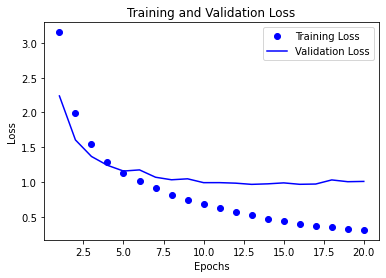

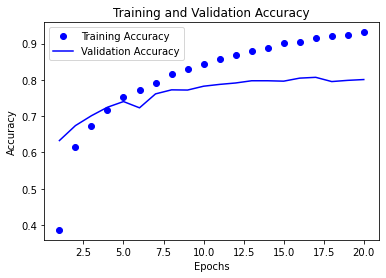

In [102]:
historyPlotLoss(history)
historyPlotAcc(history)

In [104]:
result = model.evaluate(x_test,y_test)
print(result)

71/71 [==============================] - 1s 14ms/step - loss: 1.0727 - accuracy: 0.7916
[1.0726510286331177, 0.7916295528411865]


# PARA BAIXO E HISTORICO DA AULA PASSADA

In [2]:
def criaDataset(n=20,slop=[2,1],intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = np.multiply(X,slop) - [0,intercept]
  y = (AUX[:,0] > AUX[:,1])*2 -1
  return X,y

def criaDatasetBlobs(n=1000,n_classes=4,std=0.02):
  X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1.0),cluster_std=0.02)
  return X,y

def criaDatasetXOR(n=100):
  X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
  y =np.array(y%2,dtype=int)
  return X,y

def criaDatasetNBlobsXOR(n=1000,n_classes=3,std=0.8):
  X,y = make_blobs(n_samples=n,centers=n_classes*2,cluster_std=std)
  y = np.array(y%n_classes,dtype=int)
  return X,y

def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y==k],
             X[:,1][y==k],
             "o",alpha=0.3)

In [3]:
def define_axes(X,margin=0.1):
  min1,max1 = X[:,0].min(), X[:,0].max()
  min2,max2 = X[:,1].min(), X[:,1].max()
  return [min1 -margin, max1 +margin,min2 -margin,max2 +margin]

    

def plotPredictions(clf,X,y=None,dims=[0,1]):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X_ = np.c_[x0.ravel(),x1.ravel()]
  #print(DEBUG,X_.shape)
  yp = clf.predict(X)
  ypred = clf.predict(X_).reshape(x0.shape)
  if y is not None: print(sum(yp==y)/len(y))
  #print(DEBUG,X_.shape,x0.shape,x1.shape,ypred.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha=0.2)

In [4]:
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.preprocessing import label_binarize


class ActivationFunction(ABC):
    @abstractstaticmethod
    def fw(a):
        pass
    @abstractstaticmethod
    def bw(a):
        pass
    @abstractstaticmethod
    def cls(a):
        pass

class Tanh(ActivationFunction):
    @staticmethod
    def fw(a):
        return expit(a)*2 -1
    @staticmethod
    def bw(a):
        return (1 - np.square(Tanh.fw(a)))
    @staticmethod
    def cls(a):
        return (a >= 0) * 2 - 1  


class Sigmoid(ActivationFunction):
    @staticmethod
    def fw(a):
        return expit(a)
    @staticmethod
    def bw(a):
        return expit(a) * (1 - expit(a))
    @staticmethod
    def cls(a):
        return (a >= 0.5) * 2 - 1 

class ReLU(ActivationFunction):
    @staticmethod
    def fw(a):
        return a * ( a > 0)
    @staticmethod
    def bw(a):
        return  (a > 0).astype(np.int8)
    @staticmethod
    def cls(a):
        return (a > 0) * 2 - 1  

In [5]:
#w = np.ndarray([[ 1. , -1. ],[ 0.9 , 0.9],[-0.9, -0.9]])
w = np.array([-1,0,1,3,4,5])

Tanh().fw(w)




array([-0.46211716,  0.        ,  0.46211716,  0.90514825,  0.96402758,
        0.9866143 ])

In [6]:
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.preprocessing import label_binarize


def accuracy(yactual,ypred):
  return sum(yactual==ypred)/len(yactual)


class TrainingAlgorithm(ABC):
  
  @abstractmethod
  def getW(self,X,y):
    pass

class PseudoInversaReg(TrainingAlgorithm):
  def __init__(self,regularization=0,history=[0]):
    self.history = history
    self.regularization = regularization
    
  def getW(self,X,y):
    w = np.linalg.inv(X.T @ X + np.identity(X.shape[1])*self.regularization) @ X.T @ y
    return w

class ELM(BaseEstimator,ClassifierMixin):
  def __init__ (self,n_hidden=10,regularization=0):
    self.n_hidden=n_hidden
    self.regularization = regularization
    self.activation = Tanh().fw
    self.training_algorithm = PseudoInversaReg(regularization=regularization)
    self.wih = None
    self.who = None
  
  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2 -1
  
  def fit(self,X,y):
    Xb = ELM.includeBias(X)
    self.wih = np.random.uniform(-1,1,size=(Xb.shape[1],self.n_hidden)) #-1 a 1 com threshold em 0
    #print(DEBUG,  Xb.shape, self.wih.shape)
    H = self.activation(Xb @ self.wih)
    Hb = ELM.includeBias(H)
    #yhot = self.encode_labels(y)
    self.who = self.training_algorithm.getW(Hb,y)#yhot)  

    return self
  
  def predict(self,X,y=None):
    Xb = ELM.includeBias(X)
    #print(DEBUG,  Xb.shape, self.wih.shape)
    H = self.activation(Xb @ self.wih)
    Hb = ELM.includeBias(H)
    a = Hb @ self.who
    return a
    

  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

class FixedWeigths():
  def __init__(self):
    self.n_hidden = 2
    self.activation = Tanh()
    self.training = PseudoInversaReg()

  def fit(self,X,y):
    # Definição manual de pesos
    self.wih = np.array([[1,0.9,-0.9],[-1,0.9,-0.9]]).T
    self.who = np.array([[ 11,-13, 12]]).T

    # Treino somenete da ultima camanda
    #H = self.activation(FixedWeigths.includeBias(X) @ self.wih)
    #Hb = FixedWeigths.includeBias(H) 
    #self.who = self.training.getW(Hb,y)
    print(DEBUG,self.wih)
    print(DEBUG,self.who)
    return self  

  
  def predict(self,X,y=None):
    Xb = FixedWeigths.includeBias(X)
    H = self.activation.fw(Xb @ self.wih)
    Hb = FixedWeigths.includeBias(H)
    return Hb @ self.who
  
  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

class MLP(BaseEstimator,ClassifierMixin):
  def __init__ (self,algorithm=FixedWeigths()):
    self.algorithm = algorithm
  
  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2 -1
  
  def fit(self,X,y):
    yhot = self.encode_labels(y)
    self.algorithm.fit(X,yhot)
    return self
  
  def predict(self,X,y=None):
    a = self.algorithm.predict(X,y)
    
    if len(self.labels) <= 2:
      idx = np.array(a>0,dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a,axis=1)

    ypred = np.array([self.labels[i] for i in idx])
    return ypred  


class Backpropagation():
  def __init__(self,n_hidden=[2],activation=Tanh(),learning_rate=0.001,max_iter=10000,regularization=0):
    self.n_hidden=n_hidden
    self.activation = activation
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.regularization=regularization
    
  def fit(self,X,y):
    self.Ws = []
    if len(self.n_hidden)==0 :
      self.Ws.append(np.random.uniform(-1,1,size=(X[1].shape[1]+1,y.shape[1])))
    else:
      self.Ws.append(np.random.uniform(-1,1,size=(X.shape[1]+1,self.n_hidden[0])))
      for i,_ in enumerate(self.n_hidden):
        if i == len(self.n_hidden)-1:
          self.Ws.append(np.random.uniform(-1,1,size=(self.n_hidden[i]+1,y.shape[1])))
        else:
          self.Ws.append(np.random.uniform(-1,1,size=(self.n_hidden[i]+1,self.n_hidden[i+1])))

    #self.wih = np.random.uniform(-1,1,size=(X.shape[1]+1,self.n_hidden))
    #self.who = np.random.uniform(-1,1,size=(self.n_hidden+1,y.shape[1]))
    for _ in range(self.max_iter):
      self.forward(X)
      self.backward(y)

    return self

  def forward(self,X):
    self.A = []
    self.Z = []
    A = X.copy()
    for i in range(len(self.n_hidden)+1):
      self.A.append(Backpropagation.includeBias(A))
      self.Z.append(self.A[-1] @ self.Ws[i])
      self.py =self.Z[-1]
      A = self.activation.fw(self.Z[-1])
    
    self.ypred = self.activation.cls(A)

    #self.Xb = Backpropagation.includeBias(X)
    #self.pH = self.Xb @ self.wih
    #self.H = self.activation.fw(self.pH)
    #self.Hb = Backpropagation.includeBias(self.H)
    #self.py = self.Hb @ self.who
    #self.posy = self.activation.fw(self.py)
    #self.ypred = self.activation.cls(self.posy)
    return self.ypred
  
  def backward(self,y):
    deltas = [y-self.py]
    grads = [self.A[-1].T @ deltas[-1]]
    for i in range(len(self.n_hidden),0,-1):
      deltas.insert(0,(deltas[0]@self.Ws[i][1:,:].T) *self.activation.bw(self.Z[i-1]) ) #0, deltas[0]@self.Ws[i][1:,:].T])*self.activation.bw(self.Z[i-1]))
      grads.insert(0, self.A[i-1].T @ deltas[0])
    for i in range(len(self.n_hidden),-1,-1):
      self.Ws[i] *= 1 -self.regularization*self.learning_rate
      self.Ws[i] += grads[i]*self.learning_rate



    #ho_delta = y-self.py
    #ho_grad = self.Hb.T @ ho_delta
    ##PULO DO GATO##
    #activation_grad = self.activation.bw(self.pH) #Derivada da função de ativação
    #ih_delta = (ho_delta @ self.who[1:,:].T)*activation_grad  #regra da cadeia f(g(x))'= f'(g(x))*g'(x), removendo o bias do who
    ###############
    #ih_grad = self.Xb.T @ ih_delta
    #self.who += ho_grad * self.learning_rate
    #self.wih += ih_grad * self.learning_rate

    
  def predict(self,X,y=None):
    return self.forward(X)
    
    #Xb = Backpropagation.includeBias(X)
    #H = self.activation.fw(Xb @ self.wih)
    #Hb = Backpropagation.includeBias(H)
    #ypre = Hb @ self.who
    #yact = self.activation.fw(ypre)
    #return self.activation.cls(yact)

  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

DEBUG [[ 1.  -1. ]
 [ 0.9  0.9]
 [-0.9 -0.9]]
DEBUG [[ 11]
 [-13]
 [ 12]]


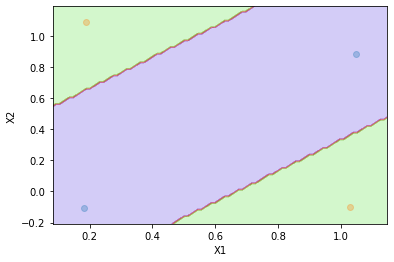

In [7]:
Xtr,ytr = criaDatasetXOR(4)
clf = MLP(algorithm=FixedWeigths())
clf.fit(Xtr,ytr)


plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr)

1.0


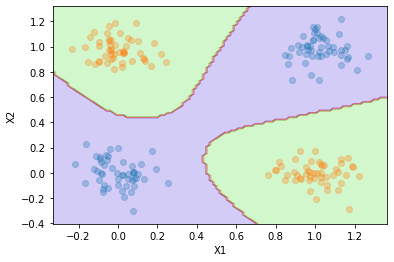

1.0


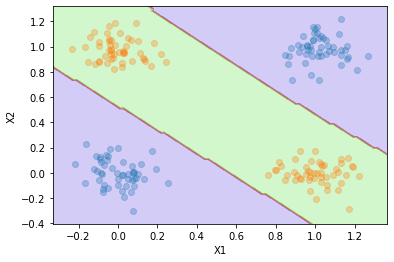

1.0


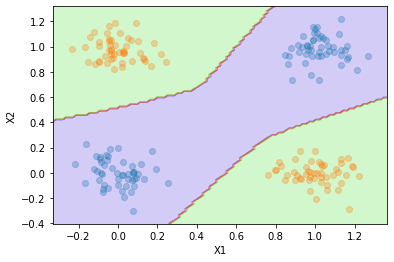

In [8]:
Xtr,ytr = criaDatasetXOR(200)
activation_list = [Tanh(),Sigmoid(),ReLU()]
for act in activation_list:
  clf = MLP(algorithm=Backpropagation(n_hidden=[8,4],activation=act,learning_rate=0.001,max_iter=10000,regularization=0))
  clf.fit(Xtr,ytr)

  #plotPredictions(clf,Xtr)
  #plt.show()

  #Xte,yte = criaDatasetNBlobsXOR(10000)
  #plotDataset(Xte,yte)
  plotDataset(Xtr,ytr)
  plotPredictions(clf,Xtr,ytr)
  plt.show()

0.93


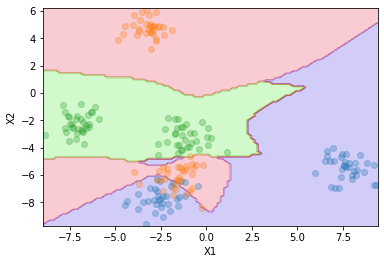

0.83


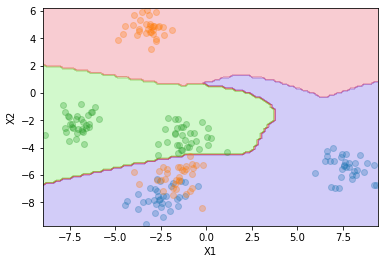

0.945


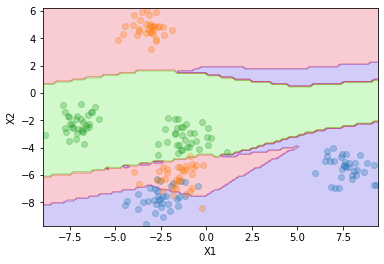

In [36]:
Xtr,ytr = criaDatasetNBlobsXOR(200,n_classes=3)
activation_list = [Tanh(),Sigmoid(),ReLU()]
for act in activation_list:
  clf = MLP(algorithm=Backpropagation(n_hidden=[8,4],activation=act,learning_rate=0.0001,max_iter=10000,regularization=1))
  clf.fit(Xtr,ytr)

  #plotPredictions(clf,Xtr)
  #plt.show()

  #Xte,yte = criaDatasetNBlobsXOR(10000)
  #plotDataset(Xte,yte)
  plotDataset(Xtr,ytr)
  plotPredictions(clf,Xtr,ytr)
  plt.show()

0.945


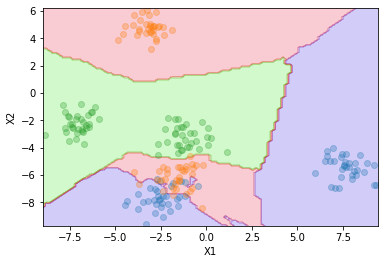

In [37]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(Xtr,ytr)

#plotPredictions(clf,Xtr)
#plt.show()

#Xte,yte = criaDatasetNBlobsXOR(10000)
#plotDataset(Xte,yte)
plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr,ytr)


# MLP Keras

In [38]:
import tensorflow as tf
from tensorflow import keras
import gc

from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model
#from tensorflow.keras.datasets import fashion_mnist
#from tqdm.keras import TqdmCallback

DEBUG = 'DEBUG: '

tf.keras.backend.clear_session()
gc.collect()

def disable_gpu_tf():
  try:
      # Disable all GPUS
      tf.config.set_visible_devices([], 'GPU')
      visible_devices = tf.config.get_visible_devices()
      for device in visible_devices:
        print(DEBUG,visible_devices)
        assert device.device_type != 'GPU'
  except:
      # Invalid device or cannot modify virtual devices once initialized.
      pass

print(DEBUG,tf.config.get_visible_devices())
disable_gpu_tf()

DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [58]:
class MLPKeras(BaseEstimator,ClassifierMixin):
  def __init__(self,max_iter=1000,n_hidden=[5,4]):
    self.max_iter = max_iter
    self.n_hidden = n_hidden

  def fit(self,X,y):
    self.labels,ids = np.unique(y,return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = keras.models.Sequential()
    self.model.add(keras.layers.InputLayer(input_shape=(X.shape[1],)))
    
    for i,h in enumerate(self.n_hidden):
      #print(DEBUG,i,h)
      self.model.add(keras.layers.Dense(h))
      if i<len(self.n_hidden)-1:
        self.model.add(keras.layers.Activation('relu'))

    self.model.add(keras.layers.Activation('relu'))
    self.model.add(keras.layers.Dense(yhot.shape[1]))
    self.model.add(keras.layers.Activation('softmax'))    
    self.model.compile(loss='categorical_crossentropy')
    self.model.fit(X,yhot,epochs=self.max_iter,verbose=0)
  
  def predict(self,X):
    predictions = self.model.predict(X)
    return self.labels[np.argmax(predictions,axis=1)]

0.93


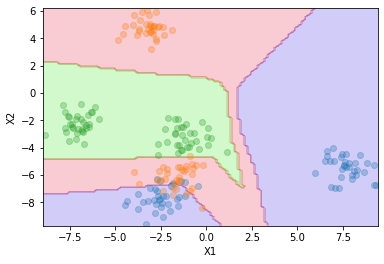

In [61]:
from sklearn.neighbors import KNeighborsClassifier
#Xtr,ytr = criaDatasetXOR(200)
clf = MLPKeras(max_iter=1000,n_hidden=[5,4])
clf.fit(Xtr,ytr)

#plotPredictions(clf,Xtr)
#plt.show()

#Xte,yte = criaDatasetNBlobsXOR(10000)
#plotDataset(Xte,yte)
plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr,ytr)